In [1]:
import gzip            
import io              
import numpy as np
import pandas as pd    
import pymysql.cursors 
import rdflib
from rdflib import Namespace
import urllib.request 
import math

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib.ticker import MaxNLocator


# Connect to the database

connection = pymysql.connect(host='hosting.nyu.edu',
                             user='cmrougha_adsq',
                             password='###REPLACE###',
                             db='cmrougha_adsq2017',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

In [2]:
g = rdflib.Graph()
g.parse('astr.ttl', format='n3')

<Graph identifier=N2d98ced4c492424d9335edb65727d4a7 (<class 'rdflib.graph.Graph'>)>

In [3]:
print("graph has %s statements." % len(g))

graph has 371278 statements.


## Investigating Texts in Sequence

The simple case looks at which texts immediately precede and follow each other most often.

In [ ]:
result = g.query(
        """
        PREFIX astr: <http://www.astronomoumenos.com/ontologies/astr.owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>
        SELECT ?work1 ?work2 ?label1 ?label2 (COUNT(*) AS ?c) WHERE {
            ?witness1 astr:witnessOf ?work1 .
            ?work1 rdfs:label ?label1 .
            ?witness1 astr:hasClaim ?claim1 .
            ?claim1 astr:immediatelyFollowedBy ?claim2 .
            ?witness2 astr:hasClaim ?claim2 .
            ?witness2 astr:witnessOf ?work2 .
            ?work2 rdfs:label ?label2 .
            ?ms astr:msContains ?witness1 .
            ?ms astr:hasClaim ?msClaim .
            ?msClaim astr:hasID ?pinID .
            }
            GROUP BY ?work1 ?work2
            ORDER BY DESC(?c)
            """)

follows = pd.DataFrame(result.bindings)

In [105]:
follows.head()

,c,label1,label2,work1,work2,count appears together,follows / appears together
0,157,Hecuba,Orestes,http://www.astronomoumenos.com/id/wo9507684,http://www.astronomoumenos.com/id/wo9589044,205.0,0.765854
1,123,Aiax,Electra,http://www.astronomoumenos.com/id/wo1688941,http://www.astronomoumenos.com/id/wo8529873,154.0,0.798701
2,102,Orestes,Phoenissae,http://www.astronomoumenos.com/id/wo9589044,http://www.astronomoumenos.com/id/wo7318064,134.0,0.761194
3,88,Prometheus uinctus,Septem contra Thebas,http://www.astronomoumenos.com/id/wo2370030,http://www.astronomoumenos.com/id/wo3645886,107.0,0.822430
4,68,Olynthiacae,Philippicae,http://www.astronomoumenos.com/id/wo2460035,http://www.astronomoumenos.com/id/wo6042193,95.0,0.715789


In [ ]:
follows["count appears together"] = np.nan
follows["follows / appears together"] = np.nan

for index, row in follows.iterrows():
    cols = list(follows)
    sparql = """
        PREFIX astr: <http://www.astronomoumenos.com/ontologies/astr.owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>
        SELECT ?ms WHERE {
            ?ms astr:msContains/astr:witnessOf <%s> .
            ?ms astr:msContains/astr:witnessOf <%s> .
            }
            
            """ % (row[cols[3]], row[cols[4]])
    result = g.query(sparql)

    follows.loc[index, "count appears together"] = int(len(result))
    follows.loc[index, "follows / appears together"] = float(row[cols[0]]) / float(len(result))
    
    if int(row[cols[0]]) > int(len(result)):
        print("Unexpected higher count for following pairs: " + str(row[cols[3]]) + " " + str(row[cols[4]]))


In [98]:
#follows
#follows[follows["count appears together"] > 9].sort_values(["follows / appears together","count appears together"], ascending=[False, False])[:300]

f = follows[follows["count appears together"] > 1]
f = f[f[list(f)[0]] != rdflib.term.Literal(1)]
f.head()

,c,label1,label2,work1,work2,count appears together,follows / appears together
0,157,Hecuba,Orestes,http://www.astronomoumenos.com/id/wo9507684,http://www.astronomoumenos.com/id/wo9589044,205.0,0.765854
1,123,Aiax,Electra,http://www.astronomoumenos.com/id/wo1688941,http://www.astronomoumenos.com/id/wo8529873,154.0,0.798701
2,102,Orestes,Phoenissae,http://www.astronomoumenos.com/id/wo9589044,http://www.astronomoumenos.com/id/wo7318064,134.0,0.761194
3,88,Prometheus uinctus,Septem contra Thebas,http://www.astronomoumenos.com/id/wo2370030,http://www.astronomoumenos.com/id/wo3645886,107.0,0.822430
4,68,Olynthiacae,Philippicae,http://www.astronomoumenos.com/id/wo2460035,http://www.astronomoumenos.com/id/wo6042193,95.0,0.715789


In [99]:
collectionLA = ('wo5649233','wo9903453','wo9036913','wo5476584','wo2055302','wo2911568','wo8243216','wo3990915','wo6962105','wo5748142','wo9989402','wo9833553')
# wo9036913 Optica wo5476584 Theon recension

In [184]:
def produceDictDF(f,collection):
    dictDF = dict()

    for work in collection:
        dictDF[work] = pd.DataFrame()
    
        f_temp = f[f[list(f)[3]] == rdflib.term.URIRef("http://www.astronomoumenos.com/id/" + work)].sort_values(["follows / appears together","count appears together"], ascending=[False, False])
        if not f_temp.empty:
            for index, row in f_temp.iterrows():
                cols = list(f_temp)
                dictDF[work].loc[index, "work"] = row[cols[1]]
                dictDF[work].loc[index, "neighbor"] = str(row[cols[2]]) + " " + str(row[cols[4]]).replace("http://www.astronomoumenos.com/id/","")
                dictDF[work].loc[index, "relationship"] = "immediatelyFollowedBy"
                dictDF[work].loc[index, "c_neighbor"] = int(row[cols[0]])
                dictDF[work].loc[index, "c_total"] = int(row[cols[5]])
                dictDF[work].loc[index, "percent"] = float(row[cols[6]])
            
        f_temp = f[f[list(f)[4]] == rdflib.term.URIRef("http://www.astronomoumenos.com/id/" + work)].sort_values(["follows / appears together","count appears together"], ascending=[False, False])
        if not f_temp.empty:
            for index, row in f_temp.iterrows():
                cols = list(f_temp)
                dictDF[work].loc[index, "work"] = row[cols[2]]
                dictDF[work].loc[index, "neighbor"] = str(row[cols[1]]) + " " + str(row[cols[3]]).replace("http://www.astronomoumenos.com/id/","")
                dictDF[work].loc[index, "relationship"] = "immediatelyPrecededBy"
                dictDF[work].loc[index, "c_neighbor"] = int(row[cols[0]])
                dictDF[work].loc[index, "c_total"] = int(row[cols[5]])
                dictDF[work].loc[index, "percent"] = float(row[cols[6]])
                
        if dictDF[work].empty:
            del dictDF[work]
        
    for key in dictDF:
        #dictDF[key] = dictDF[key].reset_index(drop=True)
        dictDF[key] = dictDF[key].sort_values(["c_neighbor","c_total"], ascending=[False, True])
    
    
    return(dictDF)


In [188]:
def graphNeighbors(dictDF):
    for key in dictDF:
        tempDF = dictDF[key].set_index('neighbor')
        convertedDF = pd.DataFrame()
        convertedDF['work'] = tempDF['work']
        convertedDF['follows text in title'] = tempDF['c_neighbor'][tempDF['relationship'] == "immediatelyFollowedBy"]
        convertedDF['precedes text in title'] = tempDF['c_neighbor'][tempDF['relationship'] == "immediatelyPrecededBy"]
        convertedDF = convertedDF.drop_duplicates()
        
        yield convertedDF.plot.barh(title=str(convertedDF['work'][0]),color=("#4286f4","#eab120"))



## Graphing Immediate Neighbors

### THE LITTLE ASTRONOMY

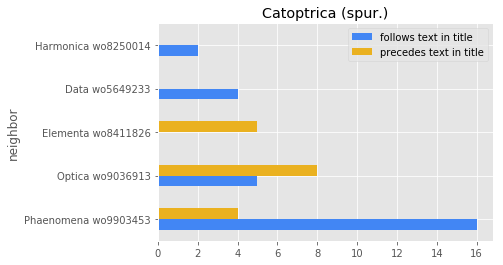

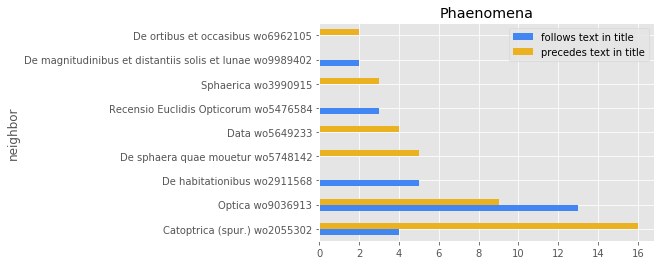

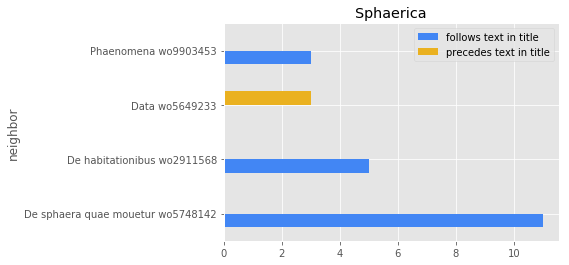

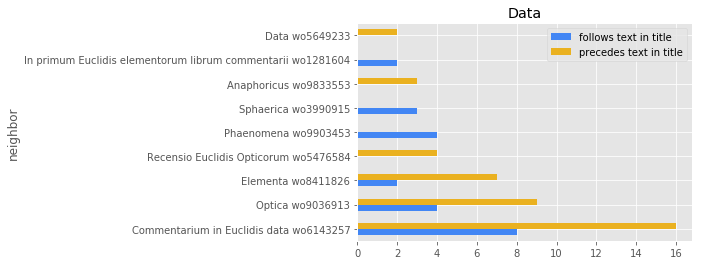

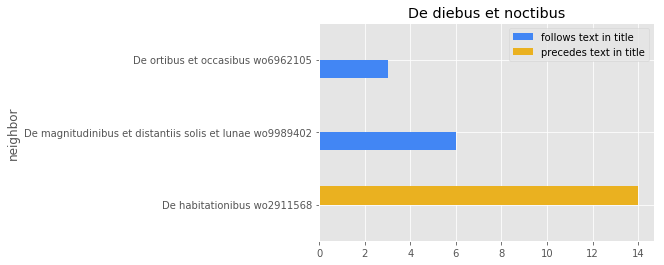

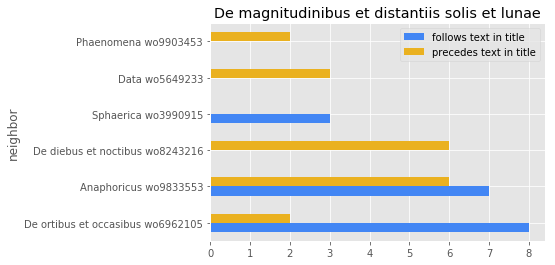

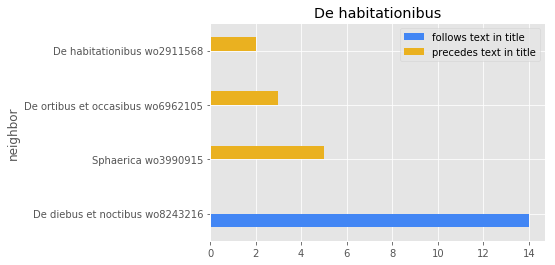

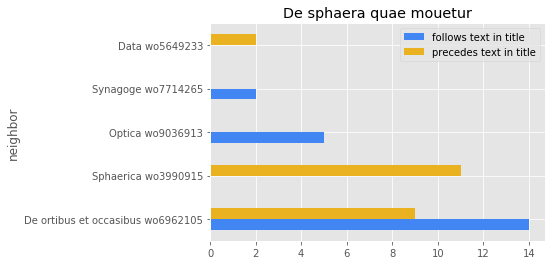

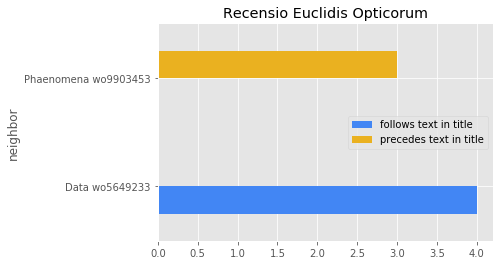

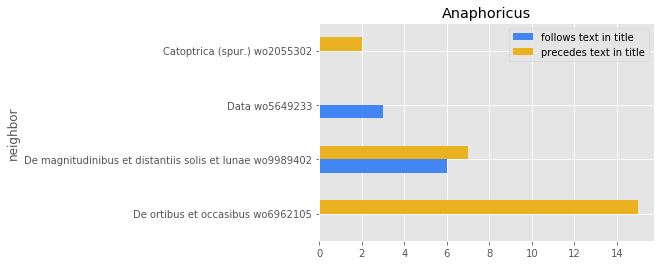

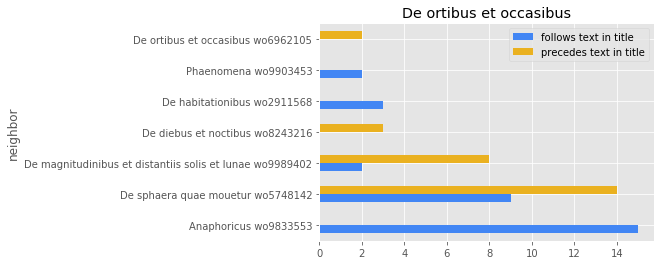

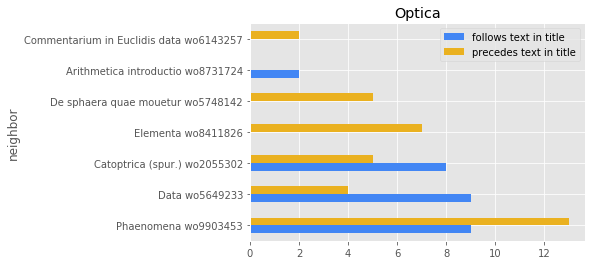

In [189]:
dictDF_LA = produceDictDF(f,collectionLA)

graph_generator = graphNeighbors(dictDF_LA)

for graph in graph_generator:
    graph

### EUCLID

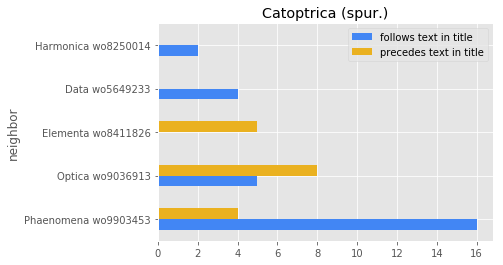

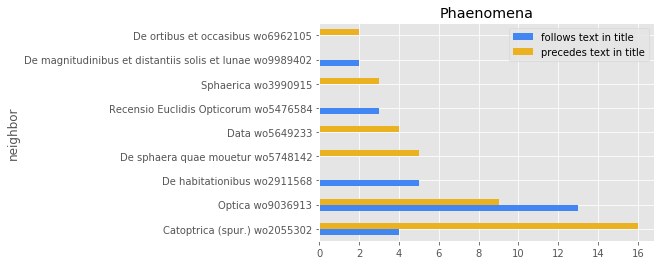

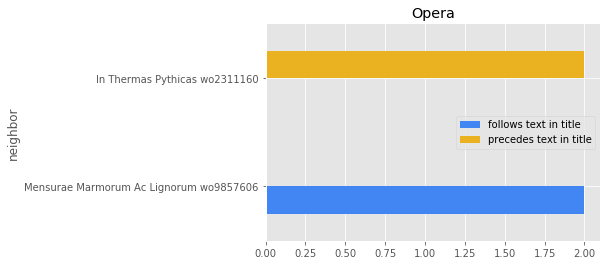

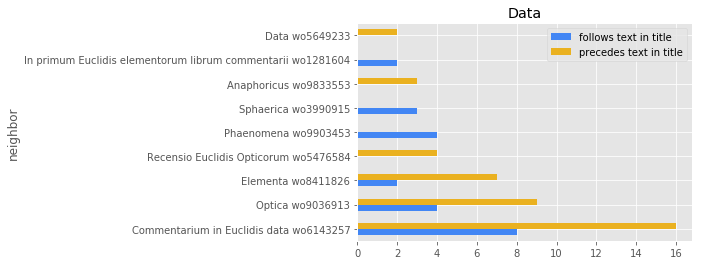

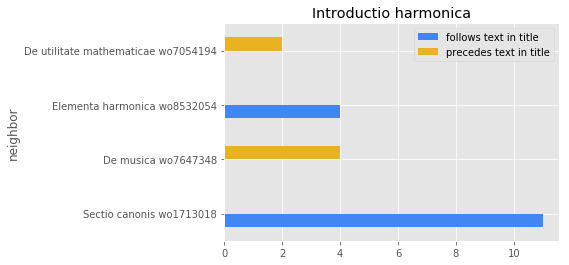

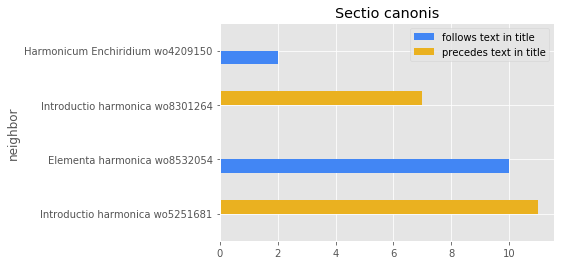

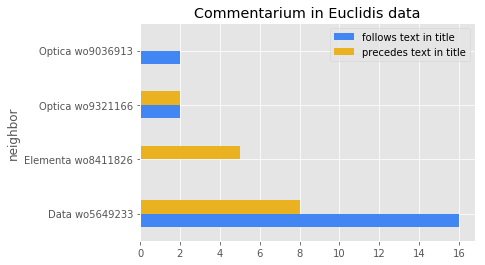

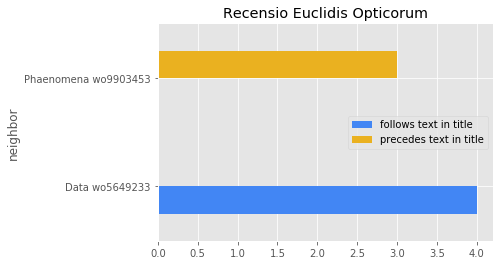

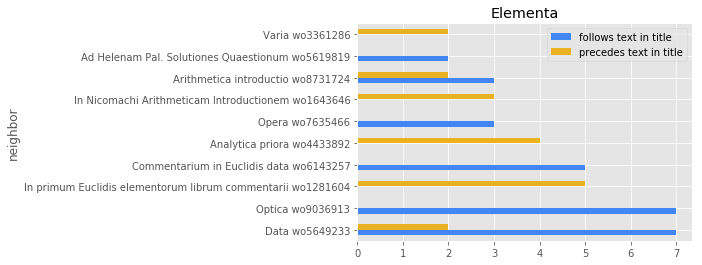

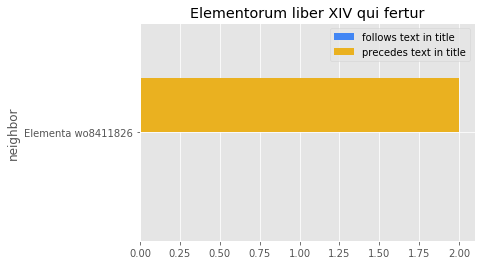

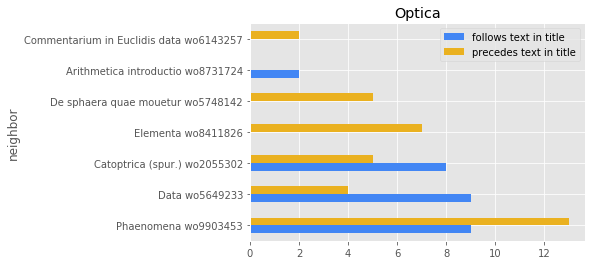

In [190]:
collectionEu = ('wo8411826','wo9903453','wo9036913','wo5265350','wo2055302','wo1713018','wo5251681','wo5649233','wo4770564','wo1946618','wo4039707','wo4039707','wo5476584','wo1422603','wo4715212','wo6143257')

dictDF_Eu = produceDictDF(f,collectionEu)

graph_generator = graphNeighbors(dictDF_Eu)

for graph in graph_generator:
    graph

### PLATO

/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


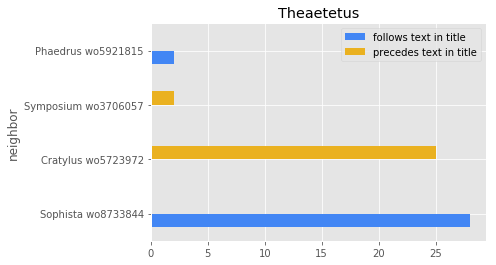

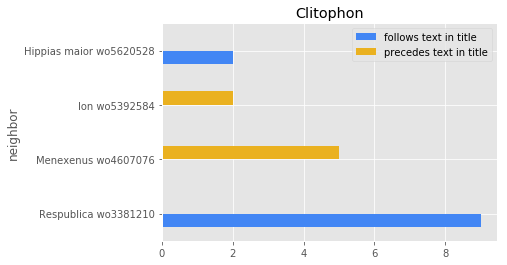

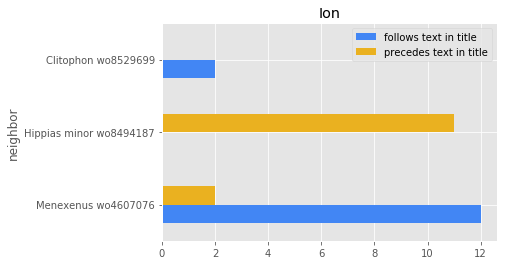

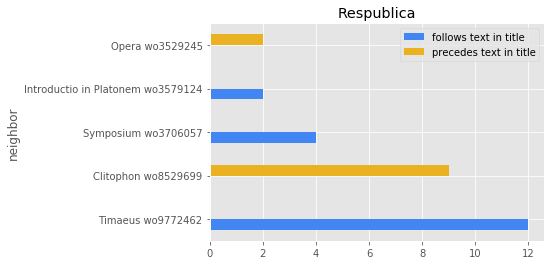

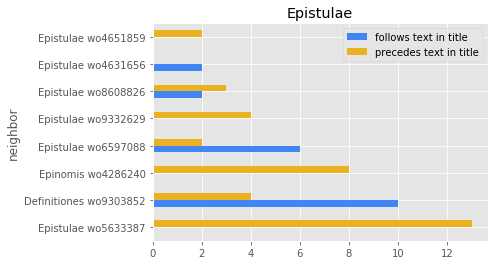

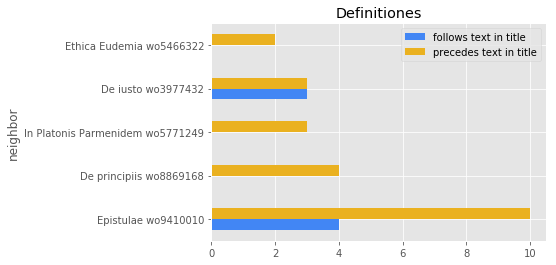

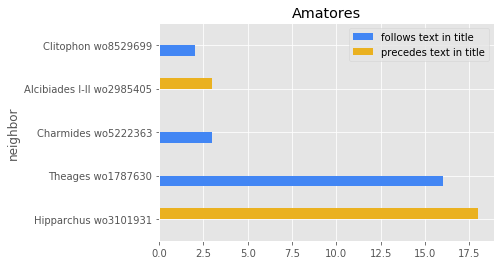

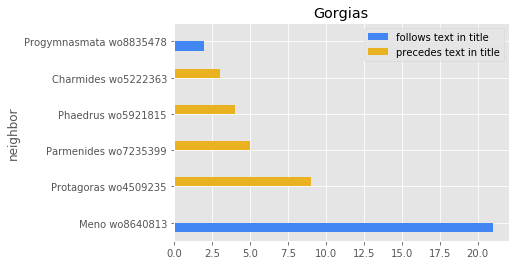

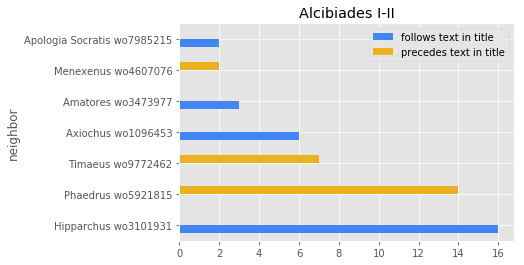

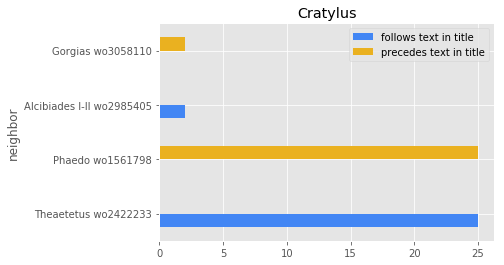

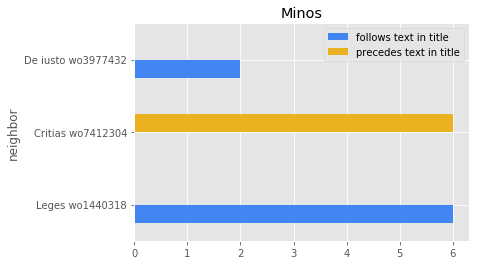

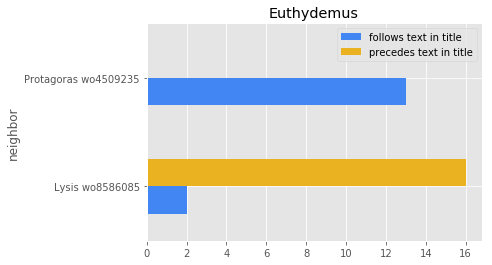

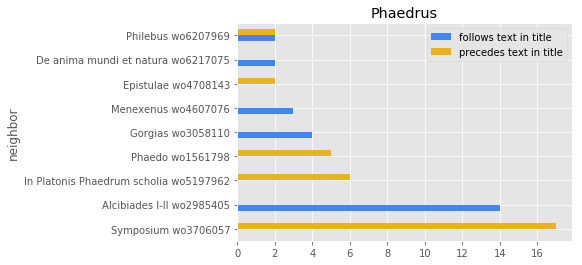

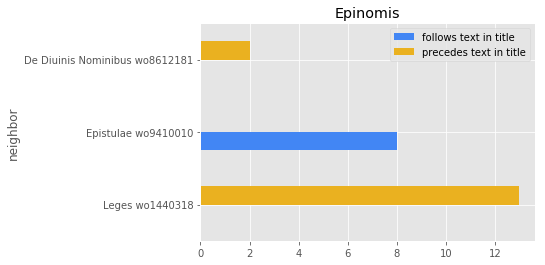

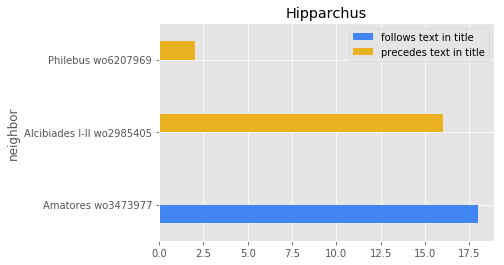

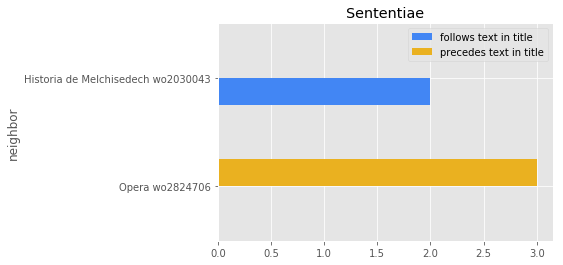

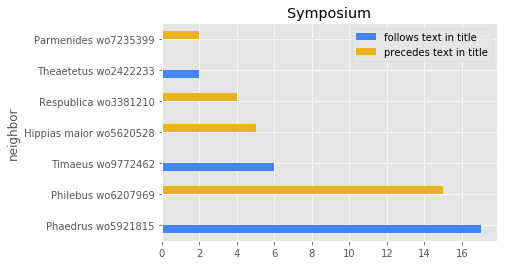

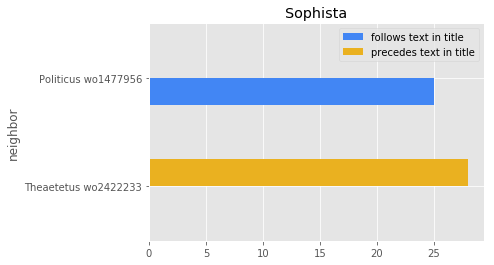

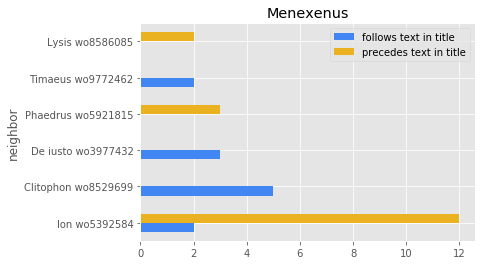

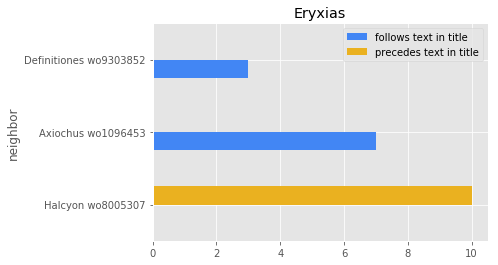

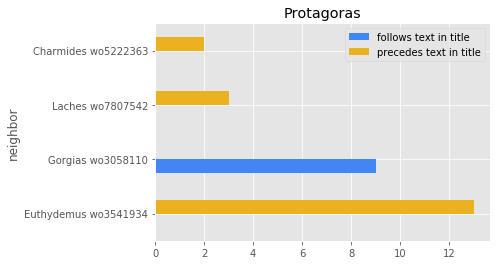

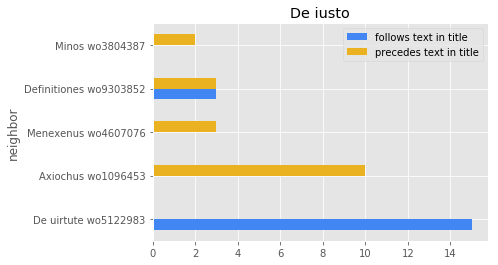

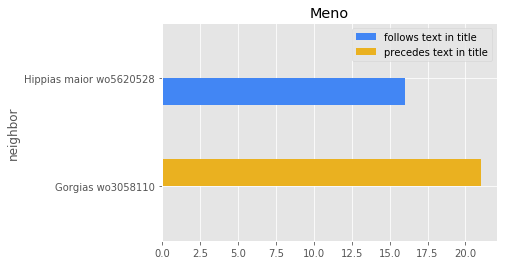

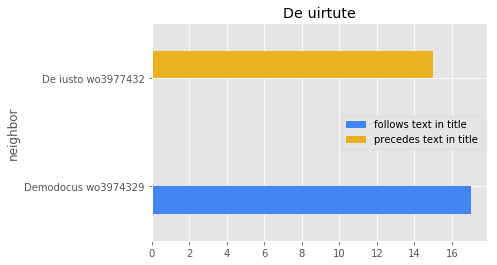

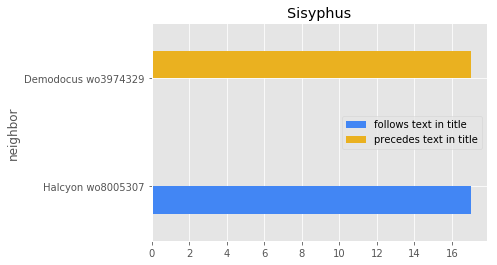

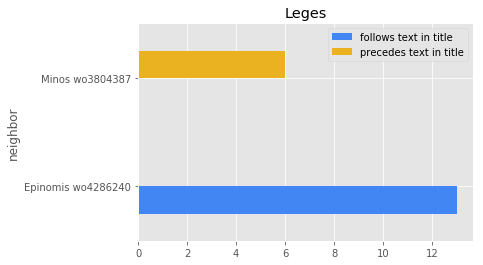

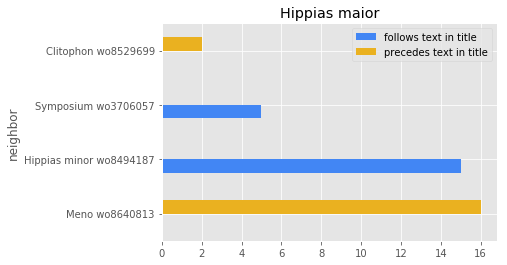

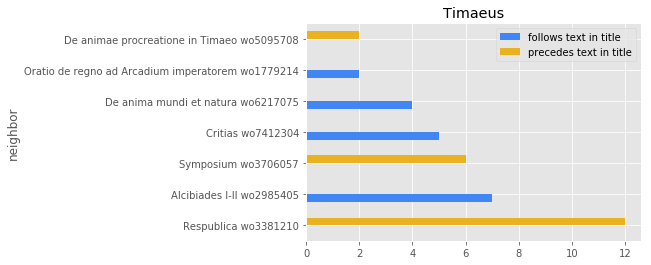

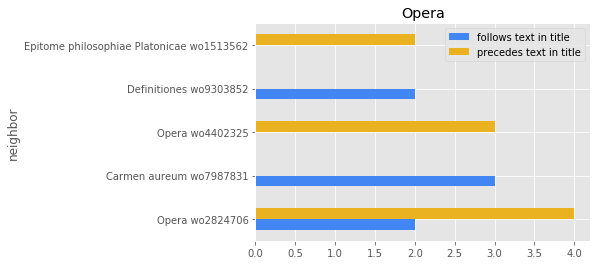

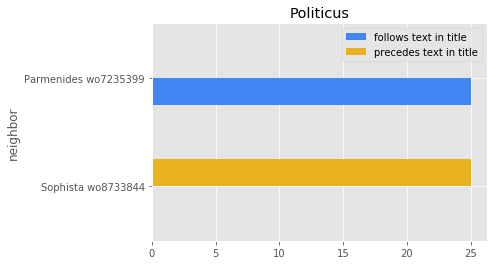

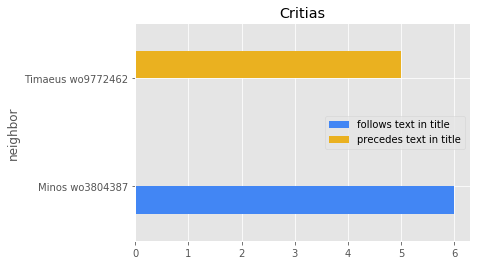

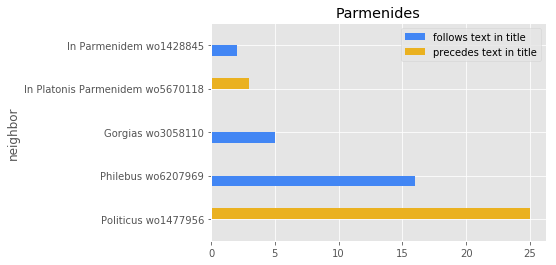

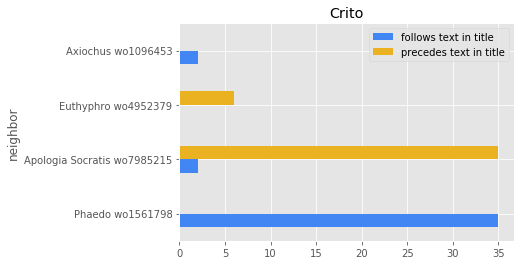

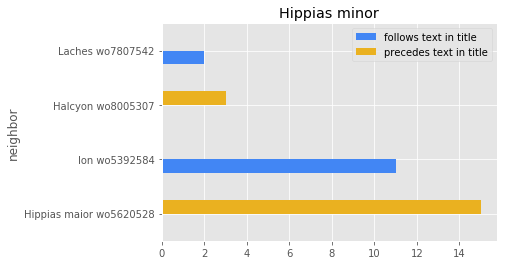

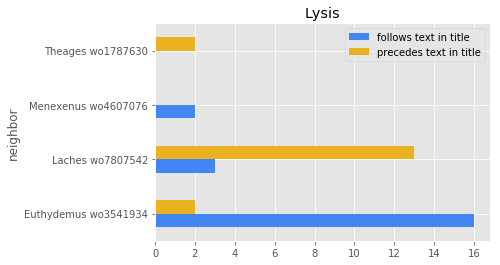

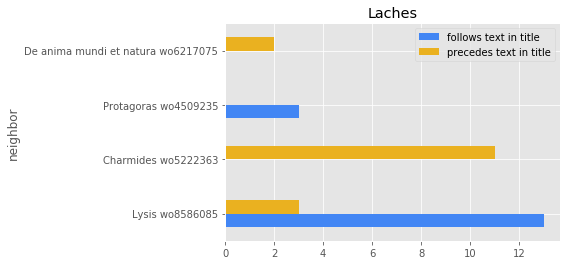

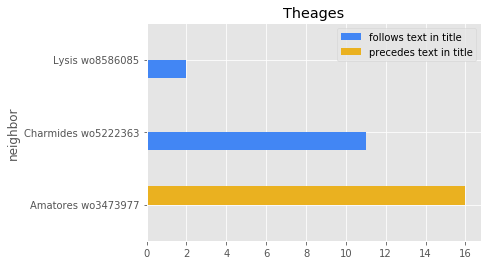

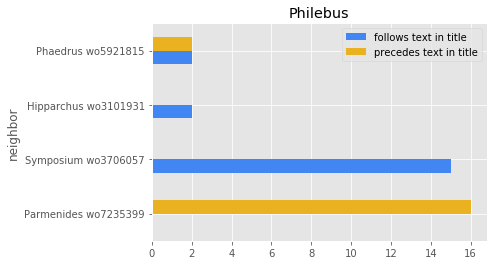

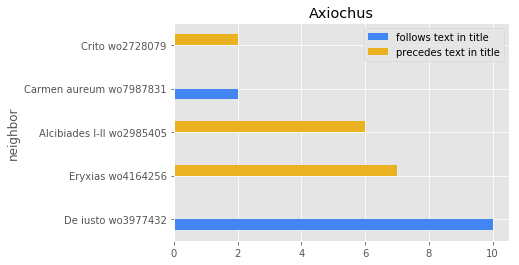

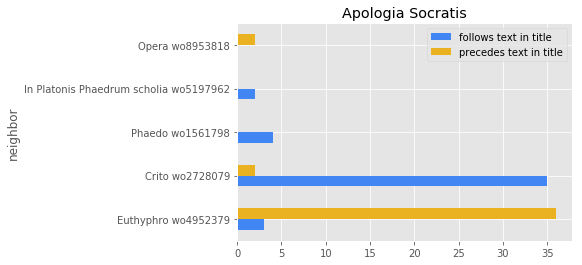

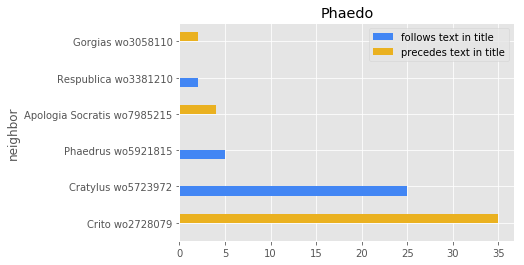

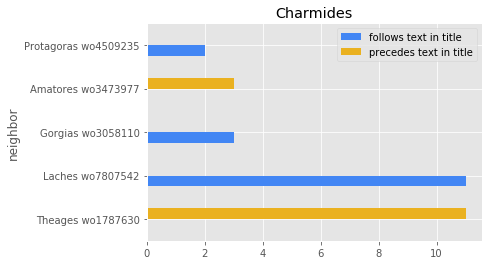

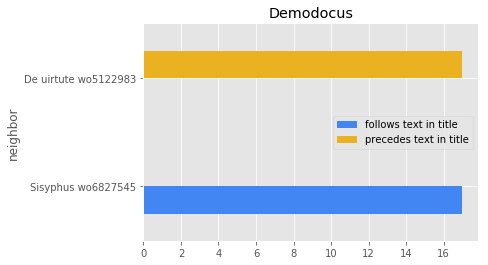

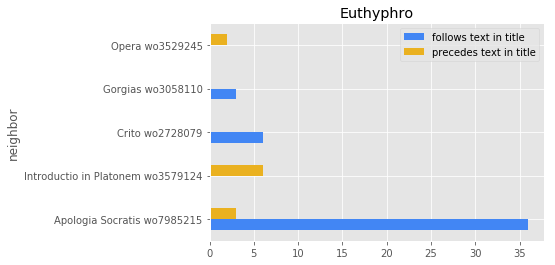

In [191]:
collectionPl = ('wo1561798','wo2728079','wo9303852','wo3529245','wo4509235','wo9410010','wo3381210','wo4952379','wo7985215','wo2985405','wo8494187','wo8640813','wo4286240','wo5222363','wo8529699','wo5620528','wo5392584','wo4607076','wo3058110','wo8586085','wo7235399','wo5723972','wo5921815','wo3706057','wo2422233','wo7871928','wo8733844','wo1477956','wo6207969','wo3541934','wo7807542','wo3473977','wo9772462','wo3101931','wo1096453','wo3977432','wo5122983','wo3974329','wo6827545','wo4164256','wo1440318','wo1787630','wo4667602','wo3804387','wo7412304')
dictDF_Pl = produceDictDF(f,collectionPl)

graph_generator = graphNeighbors(dictDF_Pl)

for graph in graph_generator:
    graph

### AESCHYLUS

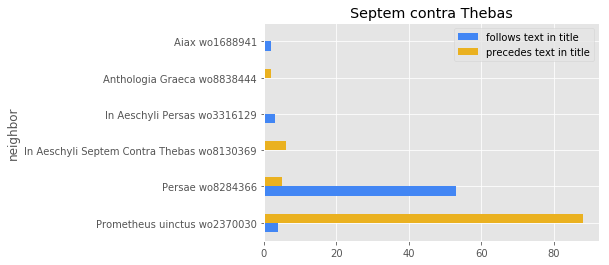

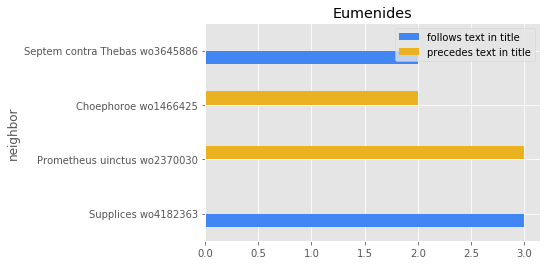

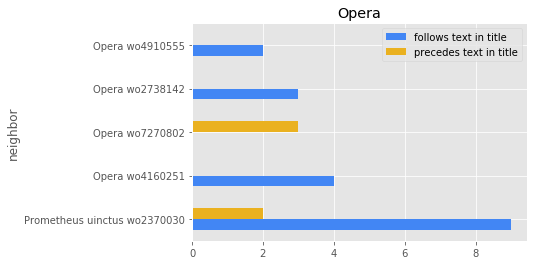

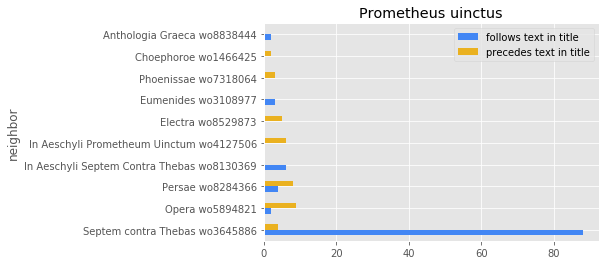

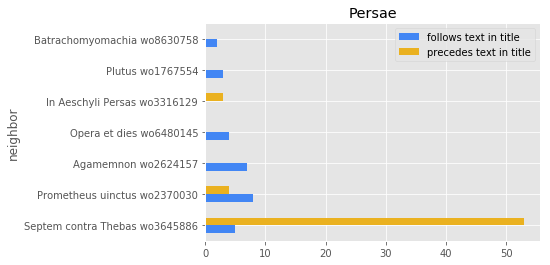

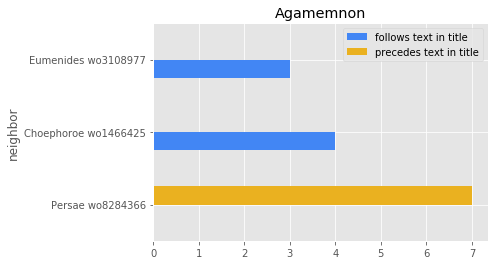

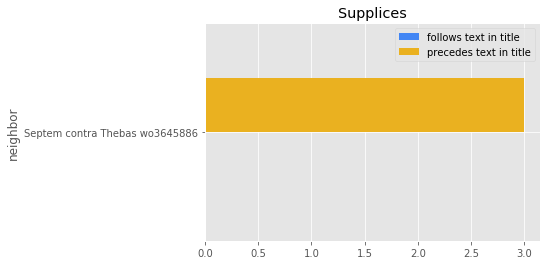

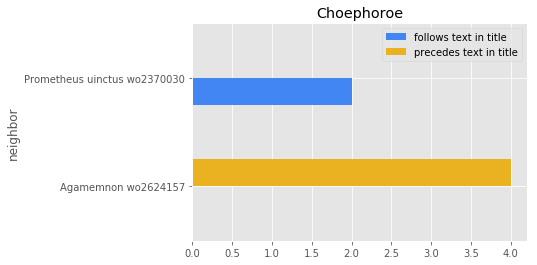

In [193]:
collectionAe = ('wo5894821','wo8284366','wo2370030','wo3645886','wo3108977','wo4182363','wo2624157','wo1466425','wo4980500')

dictDF_Ae = produceDictDF(f,collectionAe)

graph_generator = graphNeighbors(dictDF_Ae)

for graph in graph_generator:
    graph

### SOPHOCLES

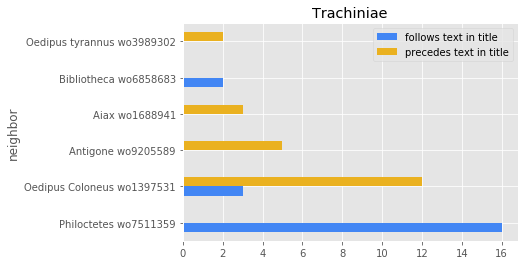

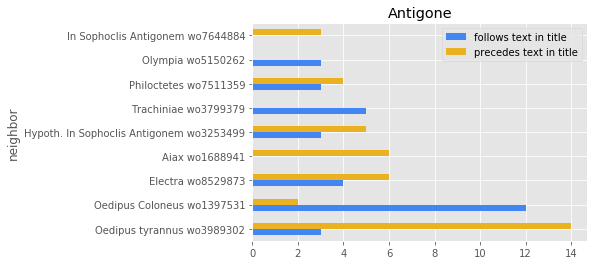

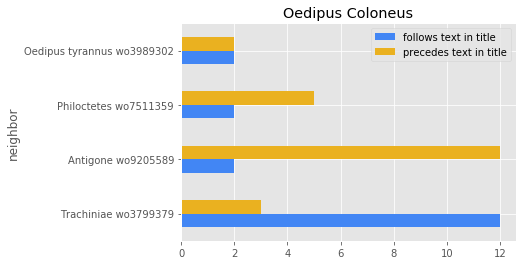

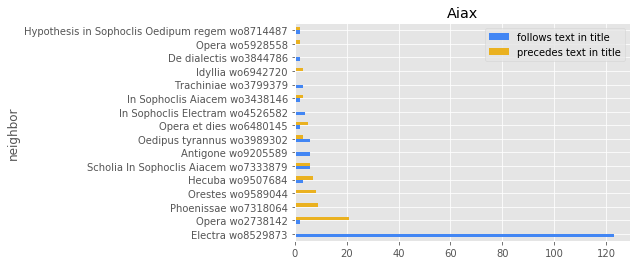

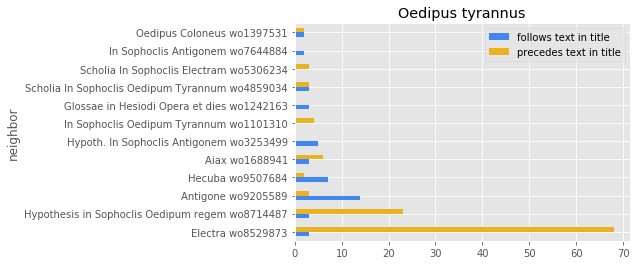

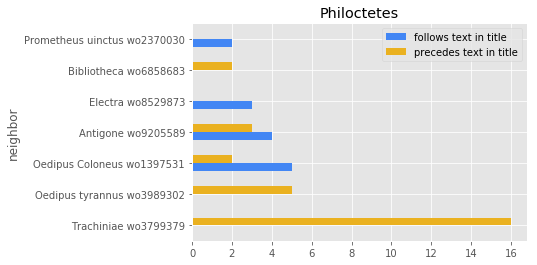

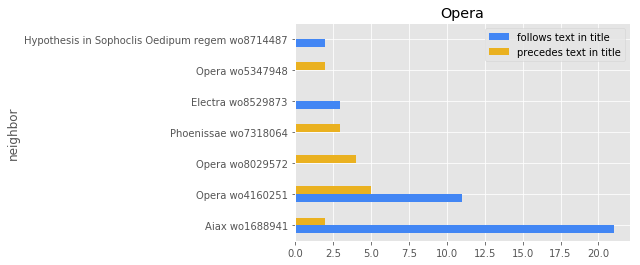

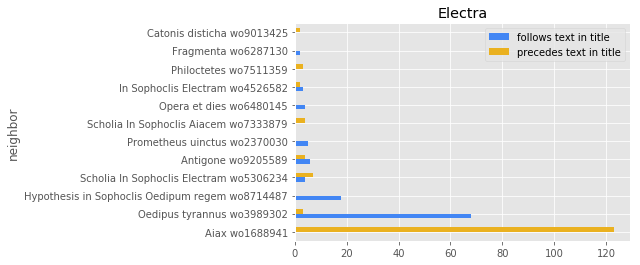

In [194]:
collectionSo = ('wo1688941','wo8529873','wo3989302','wo9205589','wo2738142','wo1397531','wo3799379','wo7511359')

dictDF_So = produceDictDF(f,collectionSo)

graph_generator = graphNeighbors(dictDF_So)

for graph in graph_generator:
    graph